In [12]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import yfinance as yf

import schedule
import time


In [21]:
#fetch data

#api = tradeapi.REST('PK0LC2J1NSMU3IUAXF31', 'VpfhPftx0Wvmkn5PoOKabFcUUHrCSxQ8LF8dri3s', base_url='https://paper-api.alpaca.markets')
api = tradeapi.REST('AKYZUR3PABG4AH39LMUC','GyCiPu5SQXovKXLl4QLe2JbXcXNfCzomjNjiVAmT','https://api.alpaca.markets')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


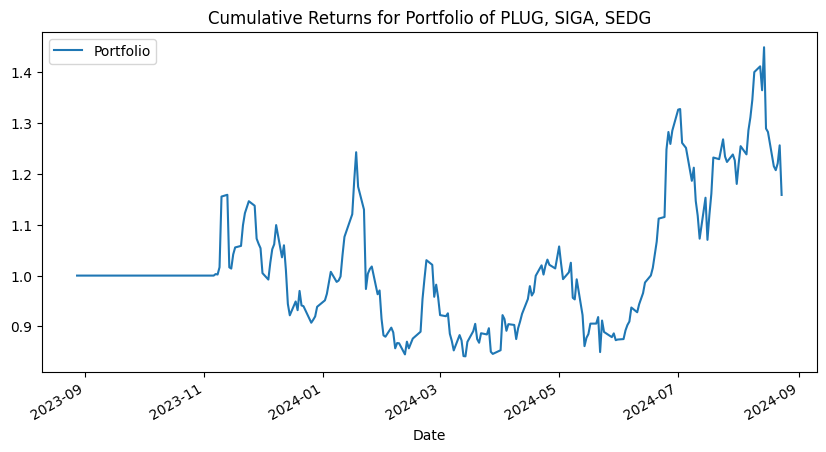

In [25]:
def fetch_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    #data = data.asfreq('D')
    return data
def compute_indicators(data):
    data['SMA_50'] = data['Close'].rolling(window=50, min_periods=1).mean()
    data['SMA_200'] = data['Close'].rolling(window=200, min_periods=1).mean()
    #data['momentum'] = data['Close'].pct_change(periods=20)
    #data['mean_reversion'] = data['Close'] - data['SMA_50']

    return data

def gensig(data):
    data['signal'] = 0
    #data['signal'][(data['SMA_50'] > data['SMA_200']) & (data['momentum'] > 0)] = 1
    #data['signal'][(data['SMA_50'] < data['SMA_200']) & (data['momentum'] < 0)] = -1
    
    data.loc[data['SMA_50'] > data['SMA_200'], 'signal'] = 1  
    data.loc[data['SMA_50'] < data['SMA_200'], 'signal'] = -1 
    return data

def backtest(data):
    data['returns'] = data['Close'].pct_change()
    data['strategy_returns'] = data['returns'] * data['signal'].shift(1)
    cumulative_returns = (1 + data['strategy_returns']).cumprod()
    return cumulative_returns

def multibacktest(symbols, start_date, end_date):
    results = {}
    cumulative_portfolio_returns = None
    
    for symbol in symbols:
        data = fetch_data(symbol, start_date, end_date)
        data = compute_indicators(data)
        data = gensig(data)
        cumulative_returns = backtest(data)
        results[symbol] = cumulative_returns
        
        if cumulative_portfolio_returns is None:
            cumulative_portfolio_returns = cumulative_returns
        else:
            cumulative_portfolio_returns += cumulative_returns
    
    cumulative_portfolio_returns /= len(symbols)
    
    return results, cumulative_portfolio_returns

def plot(cumulative_portfolio_returns, symbols):
    plt.figure(figsize=(10, 5))
    cumulative_portfolio_returns.plot(label="Portfolio")
    plt.title(f'Cumulative Returns for Portfolio of {", ".join(symbols)}')
    plt.legend()
    plt.show()

symbols = ['PLUG', 'SIGA', 'SEDG']
start = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
end = datetime.now().strftime('%Y-%m-%d')

backtest_results, cumulative_portfolio_returns = multibacktest(symbols, start, end)

plot(cumulative_portfolio_returns, symbols)



In [24]:


def place_order(symbol, side, qty):
    try:
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type='market',
            time_in_force='day'
        )
        print(f"Order placed: {side} {qty} shares of {symbol}")
    except Exception as e:
        print(f"Failed to place order for {symbol}: {e}")

def execute_trades(symbols):
    for symbol in symbols:
        data = fetch_data(symbol,start_date,end_date)
        data = compute_indicators(data)
        data = gensig(data)

        latest_signal = data['signal'].iloc[-1]

        if latest_signal == 1:
            place_order(symbol, 'buy', 0.1) 
            print(f'Order placed: Buy 10 shares of {symbol}')
        elif latest_signal == -1:
            place_order(symbol, 'sell', 0.1) 
            print(f'Order placed: Sell 10 shares of {symbol}')
        else:
            print(f"No action for {symbol}.")

symbols = ['PLUG', 'SIGA', 'SEDG', 'POET']
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

def job():
    print('Job is running')
    execute_trades(symbols)

while True:
    job()
    print("Running pending tasks...") 
    time.sleep(1)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed

Job is running



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG
Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA



[*********************100%%**********************]  1 of 1 completed


Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG
Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Job is running
Failed to place order for PLUG: account is not allowed to short
Order placed: Sell 10 shares of PLUG



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Failed to place order for SIGA: cost basis must be >= minimal amount of order 1
Order placed: Buy 10 shares of SIGA
Failed to place order for SEDG: account is not allowed to short
Order placed: Sell 10 shares of SEDG


Failed to place order for POET: asset "POET" is not fractionable
Order placed: Buy 10 shares of POET
Running pending tasks...


KeyboardInterrupt: 